# **Elliptic++ Actors (Wallet Addresses) Dataset**

***Note: "Actor" refers to a Bitcoin wallet address***

---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---



## [SETUP] Import libraries and csv files 

Download dataset from: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_classes.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrTx_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/TxAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features_classes_combined.csv ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go 
import plotly.offline as py 
import math
from collections import Counter

!pip install -U ipython 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone 

import xgboost as xgb

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 17.7 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=4ad64e3b8b283172c1ae01f750cdea27fcc42eeef533a5a0428c77fa474f08d2
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

## Actors Dataset Overview


---

This section loads the 5 csv files (wallets_features, wallets_classes, AddrAddr_edgelist, AddrTx_edgelist, TxAddr_edgelist) and provides a quick overview of the dataset structure and features.

Load saved actors dataset csv files:

In [ ]:
print("\nActors features: \n")
df_wallets_features = pd.read_csv("wallets_features.csv")
df_wallets_features

print("\nActors Classes: \n")
df_wallets_classes = pd.read_csv("wallets_classes.csv")
df_wallets_classes

print("\nAddress-Address edgelist: \n") #Actor Interaction graph edgelist
df_AddrAddr_edgelist = pd.read_csv("AddrAddr_edgelist.csv")
df_AddrAddr_edgelist

print("\nAddress-Transaction edgelist: \n") #Address-Transaction graph edgelist
df_AddrTx_edgelist = pd.read_csv("AddrTx_edgelist.csv")
df_AddrTx_edgelist

print("\nTransaction-Address edgelist: \n") #Address-Transaction graph edgelist
df_TxAddr_edgelist = pd.read_csv("TxAddr_edgelist.csv")
df_TxAddr_edgelist

# combined features and classes csv files for convenience
df_wallets_features_classes_combined = pd.read_csv("wallets_features_classes_combined.csv")


Actors features: 



,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,439586.0,...,0.0,0.0,0.000000,0.0,0.0,24.0,1.0,1.0,1.0,1.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268255,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,31,1.0,1.0,451684.0,451685.0,1.0,2.0,451685.0,451684.0,...,0.0,0.0,0.000000,0.0,0.0,3.0,1.0,1.0,1.0,1.0
1268256,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,44,0.0,1.0,477895.0,477895.0,0.0,1.0,0.0,477895.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268257,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,9,0.0,1.0,407342.0,407342.0,0.0,1.0,0.0,407342.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268258,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3,0.0,1.0,395235.0,395235.0,0.0,1.0,0.0,395235.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0



Actors Classes: 



,address,class
0,111112TykSw72ztDN2WJger4cynzWYC5w,2
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,3
2,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,2
3,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,3
4,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,2
...,...,...
822937,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,3
822938,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,3
822939,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,3
822940,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3



Address-Address edgelist: 



,input_address,output_address
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
1,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
2,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
3,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c
4,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA
...,...,...
2868959,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh
2868960,3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi,38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa
2868961,34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R,3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM
2868962,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2



Address-Transaction edgelist: 



,input_address,txId
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127
1,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,230325139
2,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,86875675
3,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,230325147
4,1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh,230325154
...,...,...
477112,1HdnGvuc21Y4QfBEHUc3NFRJhGywdSFUb,157659046
477113,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh,157659306
477114,3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi,157668825
477115,34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R,125788182



Transaction-Address edgelist: 



,txId,output_address
0,230325127,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
1,230325127,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
2,230325139,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
3,86875675,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c
4,86875675,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA
...,...,...
837119,157659306,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh
837120,157668825,38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa
837121,125788182,3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM
837122,157670868,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2


Data structure for an example actor (address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K):

In [ ]:
print("\nwallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_features[df_wallets_features['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nwallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_classes[df_wallets_classes['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nAddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrAddr_edgelist[(df_AddrAddr_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K') | (df_AddrAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K')]

print("\nAddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrTx_edgelist[df_AddrTx_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nTxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_TxAddr_edgelist[df_TxAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']


wallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
1149250,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149251,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149252,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149253,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149254,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,24,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149666,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149667,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149668,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149669,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0



wallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



,address,class
745591,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,1



AddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,input_address,output_address
1317522,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,131fHSzsK1eQJp7bC94JVWZqJ2JcdR5UfS
1317523,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1317634,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,1FCw4XNAP6xeWMF4o3RaNENguE9qFumgpn
1317635,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1317644,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
...,...,...
1592119,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1592120,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1592121,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32ZkfqSGoxdx5UGo8YQp1tFhSv8R982Usk
1592122,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



AddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,input_address,txId
235194,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,291338524
235250,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,88250674
235255,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,331553508
235256,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,331553509
239085,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,289228146
...,...,...
298647,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110135
298648,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110139
298649,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,343635736
298650,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110144



TxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,txId,output_address
431088,291338524,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431200,88250674,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431209,331553508,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431212,331553509,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
436269,289228146,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
...,...,...
539069,355110135,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539071,355110139,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539073,343635736,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539074,355110144,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



Actors features --- class, 28 transaction-related features, 27 time-related features:

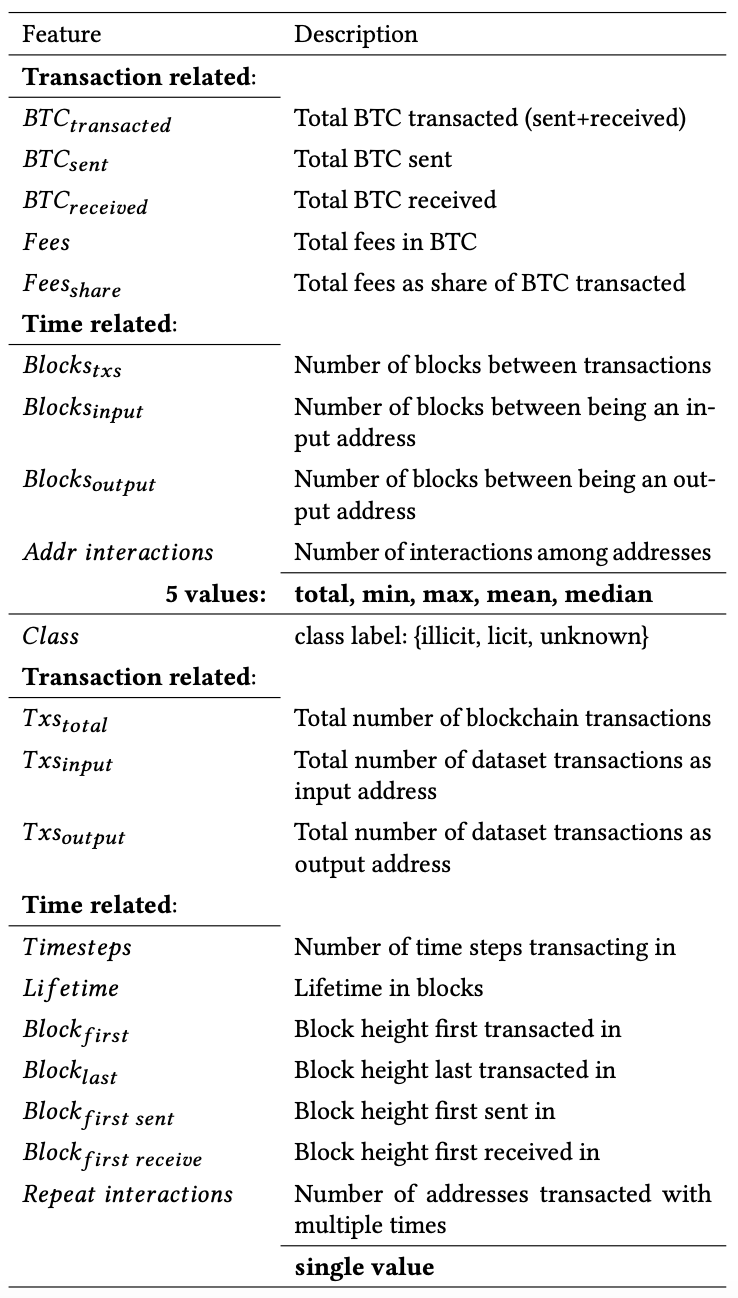


In [ ]:
df_wallets_features.columns

Index(['address', 'Time step', 'num_txs_as_sender', 'num_txs_as receiver',
       'first_block_appeared_in', 'last_block_appeared_in',
       'lifetime_in_blocks', 'total_txs', 'first_sent_block',
       'first_received_block', 'num_timesteps_appeared_in',
       'btc_transacted_total', 'btc_transacted_min', 'btc_transacted_max',
       'btc_transacted_mean', 'btc_transacted_median', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'btc_sent_median',
       'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'btc_received_median', 'fees_total', 'fees_min',
       'fees_max', 'fees_mean', 'fees_median', 'fees_as_share_total',
       'fees_as_share_min', 'fees_as_share_max', 'fees_as_share_mean',
       'fees_as_share_median', 'blocks_btwn_txs_total', 'blocks_btwn_txs_min',
       'blocks_btwn_txs_max', 'blocks_btwn_txs_mean', 'blocks_btwn_txs_median',
       'blocks_btwn_input_txs_total', 'blocks_btwn_input_txs_min',
       

## Machine Learning Model Classification


---

This section does data preprocessing, creates the training and testing sets, and runs the Logistic Regression, Random Forest, Multilayer Perceptrons, and XGBoost models as well as the ensembles on the dataset.
<br>

It's important to note that 2 types of classifications can be done: (i) classify addresses using their features, (ii) classify addresses across time steps using their features and temporal interactions. The former is more intuitive, thus, shown in this tutorial. 


Create set of addresses, their class label, and all their features for classification of (i) from above:

In [ ]:
df_wallets_classification = df_wallets_features_classes_combined
df_wallets_classification = df_wallets_classification.drop(columns=['Time step']).drop_duplicates()
df_wallets_classification

,address,class,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,2,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,439586.0,...,0.0,0.0,0.000000,0.0,0.0,24.0,1.0,1.0,1.0,1.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,3,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
9,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,2,0.0,1.0,431522.0,431522.0,0.0,1.0,0.0,431522.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
10,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,3,1.0,1.0,423456.0,423456.0,0.0,2.0,423456.0,423456.0,...,0.0,0.0,0.000000,0.0,0.0,4.0,1.0,1.0,1.0,1.0
12,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,2,0.0,1.0,429513.0,429513.0,0.0,1.0,0.0,429513.0,...,0.0,0.0,0.000000,0.0,0.0,5.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268254,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,3,1.0,1.0,451684.0,451685.0,1.0,2.0,451685.0,451684.0,...,0.0,0.0,0.000000,0.0,0.0,3.0,1.0,1.0,1.0,1.0
1268256,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,3,0.0,1.0,477895.0,477895.0,0.0,1.0,0.0,477895.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268257,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,3,0.0,1.0,407342.0,407342.0,0.0,1.0,0.0,407342.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268258,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3,0.0,1.0,395235.0,395235.0,0.0,1.0,0.0,395235.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0


Data transformation on the features using MinMaxScaler:

In [ ]:
for column in df_wallets_classification.columns[2:]:
    feature = np.array(df_wallets_classification[column]).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(feature)
    feature_scaled = scaler.transform(feature)
    df_wallets_classification[column] = feature_scaled.reshape(1,-1)[0]

df_wallets_classification

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

MinMaxScaler()

,address,class,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,2,0.000000,0.001825,0.499985,0.499985,0.000000,0.000000,0.000000,0.900837,...,0.0,0.000000,0.000000,0.000000,0.0,0.000608,0.0,0.0,0.0,0.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,3,0.000000,0.014599,0.500015,0.979168,0.479153,0.004762,0.000000,0.900843,...,0.0,0.208377,0.068456,0.083293,0.0,0.000185,0.0,0.0,0.0,0.0
9,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,2,0.000000,0.001825,0.416657,0.416657,0.000000,0.000000,0.000000,0.884312,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
10,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,3,0.000688,0.001825,0.333309,0.333309,0.000000,0.000680,0.867782,0.867782,...,0.0,0.000000,0.000000,0.000000,0.0,0.000079,0.0,0.0,0.0,0.0
12,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,2,0.000000,0.001825,0.395898,0.395898,0.000000,0.000000,0.000000,0.880195,...,0.0,0.000000,0.000000,0.000000,0.0,0.000106,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268254,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,3,0.000688,0.001825,0.624996,0.625006,0.000010,0.000680,0.925631,0.925629,...,0.0,0.000000,0.000000,0.000000,0.0,0.000053,0.0,0.0,0.0,0.0
1268256,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,3,0.000000,0.001825,0.895841,0.895841,0.000000,0.000000,0.000000,0.979343,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1268257,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,3,0.000000,0.001825,0.166799,0.166799,0.000000,0.000000,0.000000,0.834760,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1268258,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3,0.000000,0.001825,0.041695,0.041695,0.000000,0.000000,0.000000,0.809949,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
# remove 'unknown' actors
data = df_wallets_classification.loc[(df_wallets_classification['class'] != 3), 'address']
df_wallets_feature_selected = df_wallets_classification.loc[df_wallets_classification['address'].isin(data)]
df_wallets_feature_selected

,address,class,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,2,0.000000,0.001825,0.499985,0.499985,0.000000,0.00000,0.00000,0.900837,...,0.0,0.0,0.0,0.0,0.0,0.000608,0.0,0.0,0.0,0.0
9,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,2,0.000000,0.001825,0.416657,0.416657,0.000000,0.00000,0.00000,0.884312,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
12,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,2,0.000000,0.001825,0.395898,0.395898,0.000000,0.00000,0.00000,0.880195,...,0.0,0.0,0.0,0.0,0.0,0.000106,0.0,0.0,0.0,0.0
13,1117wASFaYgJJP6MiY8cPD5DMdQda8gDZ,2,0.000688,0.001825,0.083379,0.083400,0.000021,0.00068,0.81822,0.818216,...,0.0,0.0,0.0,0.0,0.0,0.000053,0.0,0.0,0.0,0.0
15,111ECNFEjJsQJ6LkAsAESBGTHBvZE66oX,2,0.000000,0.001825,0.333371,0.333371,0.000000,0.00000,0.00000,0.867794,...,0.0,0.0,0.0,0.0,0.0,0.000264,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268243,3R2KQxz2Uk7xF9bfDGffTn52NrfnBjdaLy,2,0.000000,0.001825,0.208360,0.208360,0.000000,0.00000,0.00000,0.843002,...,0.0,0.0,0.0,0.0,0.0,0.000079,0.0,0.0,0.0,0.0
1268244,3R2LAgPtnjeU2XdyR1GUXaTzKmh81VETYm,2,0.000000,0.001825,0.458331,0.458331,0.000000,0.00000,0.00000,0.892576,...,0.0,0.0,0.0,0.0,0.0,0.000106,0.0,0.0,0.0,0.0
1268251,3R2SZEK2UggNm1ntkXTe8eoea11sxg9vjw,2,0.000000,0.001825,0.312508,0.312508,0.000000,0.00000,0.00000,0.863657,...,0.0,0.0,0.0,0.0,0.0,0.000211,0.0,0.0,0.0,0.0
1268252,3R2TfX1PDN93SHbDXZqYPCn1cgmCeLMBra,2,0.000000,0.001825,0.479173,0.479173,0.000000,0.00000,0.00000,0.896710,...,0.0,0.0,0.0,0.0,0.0,0.000264,0.0,0.0,0.0,0.0


Split the data into training and testing sets with 70/30 split:

In [ ]:
# Goal: binary classification of 0,1
# 0: licit, 1: illicit

# change illicit (class-2) to '0' for classification
y = df_wallets_feature_selected[['class']]
y = y['class'].apply(lambda x: 0 if x == 2 else 1 )

X_train, X_test, y_train, y_test = train_test_split(df_wallets_feature_selected,y,test_size=0.30,random_state=15, shuffle=False)
X_train = X_train.drop(columns=['address', 'class'])
X_test = X_test.drop(columns=['address', 'class'])

Run classifiers (LR, RF, MLP, XGB):

In [ ]:
# LOGISTIC REGRESSION (LR)
cLR = LogisticRegression(max_iter=1000).fit(X_train.values,y_train.values)
y_preds_LR = cLR.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_LR)

print("Logistic Regression")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_LR, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

Logistic Regression
Precision: 0.477 
Recall: 0.046 
F1 Score: 0.083
Micro-Average F1 Score: 0.964


In [ ]:
# RANDOM FOREST (RF)
cRF = RandomForestClassifier(n_estimators=50).fit(X_train.values,y_train.values)
y_preds_RF = cRF.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_RF)

print("Random Forest 50 trees")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_RF, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

Random Forest 50 trees
Precision: 0.911 
Recall: 0.789 
F1 Score: 0.845
Micro-Average F1 Score: 0.990


In [ ]:
# MULTILAYER PERCEPTRON (MLP)
cMLP = MLPClassifier(solver='adam', learning_rate_init=0.001, max_iter=500).fit(X_train.values,y_train.values)
y_preds_MLP = cMLP.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_MLP)

print("Multilayer Perceptron (MLP)")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_MLP, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

Multilayer Perceptron (MLP)
Precision: 0.747 
Recall: 0.413 
F1 Score: 0.532
Micro-Average F1 Score: 0.974


In [ ]:
# XGBOOST (XGB)
cXGB = xgb.XGBClassifier(objective="multi:softmax", num_class=2, random_state=42)
cXGB.fit(X_train.values, y_train.values)
y_preds_XGB = cXGB.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_XGB)

print("XGBOOST")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_XGB, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

XGBOOST
Precision: 0.869 
Recall: 0.534 
F1 Score: 0.662
Micro-Average F1 Score: 0.980


Run ensemble classifiers (RF+MLP, RF+XGB, MLP+XGB, RF+MLP+XGB):

In [ ]:
#create a dictionary of our models
estimatorsRFMLP=[('MLP', cMLP), ('RF', cRF)]
#create our voting classifier, inputting our models
ensembleRFMLP = VotingClassifier(estimatorsRFMLP, voting='hard')
ensembleRFMLP.fit(X_train.values, y_train.values)
y_preds_RFMLP = ensembleRFMLP.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_RFMLP)

print("Ensemble: Random Forest (RF) + Multilayer Perceptron (MLP)")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_RFMLP, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

Ensemble: Random Forest (RF) + Multilayer Perceptron (MLP)
Precision: 0.967 
Recall: 0.403 
F1 Score: 0.568
Micro-Average F1 Score: 0.978


In [ ]:
#create a dictionary of our models
estimatorsXGBRF=[('RF', cRF), ('XGB', cXGB)]
#create our voting classifier, inputting our models
ensembleXGBRF = VotingClassifier(estimatorsXGBRF, voting='hard')
ensembleXGBRF.fit(X_train.values, y_train.values)
y_preds_XGBRF = ensembleXGBRF.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_XGBRF)

print("Ensemble: XGBoost (XGB) + Random Forest (RF)")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_XGBRF, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

Ensemble: XGBoost (XGB) + Random Forest (RF)
Precision: 0.959 
Recall: 0.530 
F1 Score: 0.682
Micro-Average F1 Score: 0.982


In [ ]:
#create a dictionary of our models
estimatorsMLPXGB=[('MLP', cMLP), ('XGB', cXGB)]
#create our voting classifier, inputting our models
ensembleMLPXGB = VotingClassifier(estimatorsMLPXGB, voting='hard')
ensembleMLPXGB.fit(X_train.values, y_train.values)
y_preds_MLPXGB = ensembleMLPXGB.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_MLPXGB)

print("Ensemble: Multilayer Perceptron (MLP) + XGBoost")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_MLPXGB, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

Ensemble: Multilayer Perceptron (MLP) + XGBoost
Precision: 0.929 
Recall: 0.324 
F1 Score: 0.481
Micro-Average F1 Score: 0.975


In [ ]:
#create a dictionary of our models
estimatorsXGBRFMLP=[('XGB', cXGB_selected), ('MLP', cMLP), ('RF', cRF)]
#create our voting classifier, inputting our models
ensembleXGBRFMLP = VotingClassifier(estimatorsXGBRFMLP, voting='hard')
ensembleXGBRFMLP.fit(X_train.values, y_train.values)
y_preds_XGBRFMLP = ensembleXGBRFMLP.predict(X_test.values)
prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_XGBRFMLP)

print("Ensemble (all): XGBoost + Random Forest (RF) + Multilayer Perceptron (MLP)")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_XGBRFMLP, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))

Ensemble (all): XGBoost + Random Forest (RF) + Multilayer Perceptron (MLP)
Precision: 0.932 
Recall: 0.571 
F1 Score: 0.709
Micro-Average F1 Score: 0.983


(LSTM not included)

# **Acknowledgements**


---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---

